In [1]:
# the sourse of code go from https://www.quantopian.com/posts/machine-learning-on-quantopian

# import libraries
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import Latest
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor, SimpleMovingAverage, AverageDollarVolume, Returns, RSI
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import Q500US, Q1500US
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from quantopian.pipeline.data.zacks import EarningsSurprises

import talib
import pandas as pd
import numpy as np
from time import time

import alphalens as al
import pyfolio as pf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics

In [2]:
#definition of factors
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_report
v = morningstar.valuation
vr = morningstar.valuation_ratios


def make_factors():
    def Asset_Growth_3M():
        return Returns(inputs=[bs.total_assets], window_length=63)

    def Asset_To_Equity_Ratio():
        return bs.total_assets.latest / bs.common_stock_equity.latest

    def Capex_To_Cashflows():
        return (cfs.capital_expenditure.latest * 4.) / \
            (cfs.free_cash_flow.latest * 4.)
        
    def EBITDA_Yield():
        return (is_.ebitda.latest * 4.) / \
            USEquityPricing.close.latest        

    def EBIT_To_Assets():
        return (is_.ebit.latest * 4.) / \
            bs.total_assets.latest
        
    def Earnings_Quality():
        return morningstar.cash_flow_statement.operating_cash_flow.latest / \
               EarningsSurprises.eps_act.latest
        
    def Return_On_Total_Invest_Capital():
        return or_.roic.latest
    
    class Mean_Reversion_1M(CustomFactor):
        inputs = [Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
                
    class MACD_Signal_10d(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 60

        def compute(self, today, assets, out, close):

            sig_lines = []

            for col in close.T:
                # get signal line only
                try:
                    _, signal_line, _ = talib.MACD(col, fastperiod=12,
                                                   slowperiod=26, signalperiod=10)
                    sig_lines.append(signal_line[-1])
                # if error calculating, return NaN
                except:
                    sig_lines.append(np.nan)
            out[:] = sig_lines 
            
    class Moneyflow_Volume_5d(CustomFactor):
        inputs = [USEquityPricing.close, USEquityPricing.volume]
        window_length = 5

        def compute(self, today, assets, out, close, volume):

            mfvs = []

            for col_c, col_v in zip(close.T, volume.T):

                # denominator
                denominator = np.dot(col_c, col_v)

                # numerator
                numerator = 0.
                for n, price in enumerate(col_c.tolist()):
                    if price > col_c[n - 1]:
                        numerator += price * col_v[n]
                    else:
                        numerator -= price * col_v[n]

                mfvs.append(numerator / denominator)
            out[:] = mfvs  
            
           
    def Net_Income_Margin():
        return or_.net_margin.latest           

    def Operating_Cashflows_To_Assets():
        return (cfs.operating_cash_flow.latest * 4.) / \
            bs.total_assets.latest

    def Price_Momentum_3M():
        return Returns(window_length=63)
    
    class Price_Oscillator(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            four_week_period = close[-20:]
            out[:] = (np.nanmean(four_week_period, axis=0) /
                      np.nanmean(close, axis=0)) - 1.
    
    def Returns_39W():
        return Returns(window_length=215)
    
    class Trendline(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / \
                (self.window_length)
        
    class Vol_3M(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 63

        def compute(self, today, assets, out, rets):
            out[:] = np.nanstd(rets, axis=0)
            
    def Working_Capital_To_Assets():
        return bs.working_capital.latest / bs.total_assets.latest   
        
    all_factors = {
        'Asset Growth 3M': Asset_Growth_3M,
        'Asset to Equity Ratio': Asset_To_Equity_Ratio,
        'Capex to Cashflows': Capex_To_Cashflows,
        'EBIT to Assets': EBIT_To_Assets,
        'EBITDA Yield': EBITDA_Yield,        
        #'Earnings Quality': Earnings_Quality,
        'MACD Signal Line': MACD_Signal_10d,
        'Mean Reversion 1M': Mean_Reversion_1M,
        'Moneyflow Volume 5D': Moneyflow_Volume_5d,
        'Net Income Margin': Net_Income_Margin,        
        'Operating Cashflows to Assets': Operating_Cashflows_To_Assets,
        'Price Momentum 3M': Price_Momentum_3M,
        'Price Oscillator': Price_Oscillator,
        'Return on Invest Capital': Return_On_Total_Invest_Capital,
        '39 Week Returns': Returns_39W,
        'Trendline': Trendline,
        'Vol 3M': Vol_3M,
        'Working Capital to Assets': Working_Capital_To_Assets,        
    }        
    
    return all_factors
factors = make_factors()

In [3]:
universe = Q500US() # Define universe and select factors to use
n_fwd_days = 5 # number of days to compute returns over

Differently to source I changed rank to zscore!  

In [4]:
# Define and build the pipeline
def make_history_pipeline(factors, universe, n_fwd_days=5):
    # Call .rank() on all factors and mask out the universe
    factor_zscore = {name: f().zscore(mask=universe) for name, f in factors.iteritems()}
    # Get cumulative returns over last n_fwd_days days. We will later shift these.
    factor_zscore['Returns'] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=n_fwd_days)
    
    # Add many returns as factors
    for i in [2,3,4,5,10,20,30,60,100,250]:
        factor_zscore ['Return'+str(i)] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=i)    
    
    #factor_zscore['SPY']=Returns(inputs=[USEquityPricing.open('SPY')] )
    
    pipe = Pipeline(screen=universe, columns=factor_zscore)
    
    return pipe
history_pipe = make_history_pipeline(factors, universe, n_fwd_days=n_fwd_days)

In [5]:
# Because of problem with  time when taken a lot of data divide time to periods
end_full = pd.Timestamp("2017-08-07")
period = pd.DateOffset(200)
number_of_periods = 5
results=pd.DataFrame()
start = end_full-number_of_periods*(period)-(number_of_periods-1)*pd.DateOffset(1)

In [6]:
# Run pipeline
start_timer = time()
while end_full>start:
    print 'start', start ,'end' ,start+period
    results_period = run_pipeline(history_pipe, start_date=start, end_date=start+period)
    start+=(period+pd.DateOffset(1))
    results_period.index.names = ['date', 'security']
    results=pd.concat([results,results_period])
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

start 2014-11-07 00:00:00 end 2015-05-26 00:00:00


/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


start 2015-05-27 00:00:00 end 2015-12-13 00:00:00
start 2015-12-14 00:00:00 end 2016-07-01 00:00:00
start 2016-07-02 00:00:00 end 2017-01-18 00:00:00
start 2017-01-19 00:00:00 end 2017-08-07 00:00:00
Time to run pipeline 873.86 secs


In [7]:
results.head()

39 Week Returns  Asset Growth 3M  \
date                      security                                              
2014-11-07 00:00:00+00:00 Equity(2 [ARNC])          1.528996        -0.040348   
                          Equity(24 [AAPL])         0.958122         0.067358   
                          Equity(62 [ABT])          0.131019        -0.164098   
                          Equity(67 [ADSK])         0.249543        -0.098946   
                          Equity(76 [TAP])          1.013989        -0.164098   

                                             Asset to Equity Ratio  \
date                      security                                   
2014-11-07 00:00:00+00:00 Equity(2 [ARNC])               -0.082989   
                          Equity(24 [AAPL])              -0.105576   
                          Equity(62 [ABT])               -0.113372   
                          Equity(67 [ADSK])              -0.106027   
                          Equity(76 [TAP])               -0.113035   

                                             Capex to Cashflows  \
date                      security                                
2014-11-07 00:00:00+00:00 Equity(2 [ARNC])             0.689135   
                          Equity(24 [AAPL])            0.027210   
                          Equity(62 [ABT])             0.027817   
                          Equity(67 [ADSK])            0.041891   
                          Equity(76 [TAP])             0.045595   

                                             EBIT to Assets  EBITDA Yield  \
date                      security                                          
2014-11-07 00:00:00+00:00 Equity(2 [ARNC])        -0.056671     -0.004957   
                          Equity(24 [AAPL])       -0.022287      0.091902   
                          Equity(62 [ABT])        -0.051799     -0.042516   
                          Equity(67 [ADSK])       -0.058198     -0.065926   
                          Equity(76 [TAP])        -0.046912     -0.060467   

                                             MACD Signal Line  \
date                      security                              
2014-11-07 00:00:00+00:00 Equity(2 [ARNC])          -0.035885   
                          Equity(24 [AAPL])          0.813169   
                          Equity(62 [ABT])           0.054042   
                          Equity(67 [ADSK])          0.166091   
                          Equity(76 [TAP])          -0.107397   

                                             Mean Reversion 1M  \
date                      security                               
2014-11-07 00:00:00+00:00 Equity(2 [ARNC])           -0.513947   
                          Equity(24 [AAPL])           0.101400   
                          Equity(62 [ABT])            0.149241   
                          Equity(67 [ADSK])          -0.345764   
                          Equity(76 [TAP])           -0.455320   

                                             Moneyflow Volume 5D  \
date                      security                                 
2014-11-07 00:00:00+00:00 Equity(2 [ARNC])              0.606974   
                          Equity(24 [AAPL])             0.498972   
                          Equity(62 [ABT])              0.031036   
                          Equity(67 [ADSK])             1.830092   
                          Equity(76 [TAP])              0.046724   

                                             Net Income Margin  \
date                      security                               
2014-11-07 00:00:00+00:00 Equity(2 [ARNC])           -0.067084   
                          Equity(24 [AAPL])          -0.014685   
                          Equity(62 [ABT])           -0.042966   
                          Equity(67 [ADSK])          -0.059615   
                          Equity(76 [TAP])           -0.001741   

                                                       ...              \
date                      security         

In [8]:
# Sometimes there are duplicated indexis
results = results[~results.index.duplicated(keep='first')]
# Massage data to be in the form expected by shift_mask_data()
results_wo_returns = results.copy()
returns = results_wo_returns.pop('Returns')
Y = returns.unstack().values
X = results_wo_returns.to_panel() 
X = X.swapaxes(2, 0).swapaxes(0, 1).values # (factors, time, stocks) -> (time, stocks, factors)
results_wo_returns.index = results_wo_returns.index.set_levels(
    results_wo_returns.index.get_level_values(1).map(lambda x: x.symbol), 1, )
results_wo_returns.index = results_wo_returns.index.set_levels(
    results_wo_returns.index.get_level_values(0).map(lambda x: x.date), 0, )

# Train-test split
train_size_perc = 0.8
n_time, n_stocks, n_factors = X.shape
train_size = np.int16(np.round(train_size_perc * n_time))
X_train, Y_train = X[:train_size, ...], Y[:train_size]
X_test, Y_test = X[(train_size+n_fwd_days):, ...], Y[(train_size+n_fwd_days):]

In [9]:
def shift_mask_data_absolut_return(X, Y, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days+1, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days+1:]
    Y = Y[n_fwd_days+1:]
    
    n_time, n_stocks, n_factors = X.shape
    level=0.01
    upper_mask = (Y > level)
    lower_mask = (Y <= level)
    
    
    # Try to predict the price go up to level 
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] =  1
    Y_binary[lower_mask.flatten()] = 0

    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))
    
    return X, Y_binary

In [10]:
def shift_mask_data(X, Y, upper_percentile=60, lower_percentile=40, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days+1, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days+1:]
    Y = Y[n_fwd_days+1:]
    
    n_time, n_stocks, n_factors = X.shape
    
    # Look for biggest up and down movers
    upper = np.nanpercentile(Y, upper_percentile, axis=1)[:, np.newaxis]
    lower = np.nanpercentile(Y, lower_percentile, axis=1)[:, np.newaxis]
  
    upper_mask = (Y >= upper)
    lower_mask = (Y <= lower)
    
    mask = upper_mask | lower_mask # This also drops nans
    mask = mask.flatten()
    
    # Only try to predict whether a stock moved up/down relative to other stocks
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] = 0
    Y_binary[lower_mask.flatten()] = 1
    
    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))

    # Drop stocks that did not move much (i.e. are in the 30th to 70th percentile)
    X = X[mask]
    Y_binary = Y_binary[mask]
    
    return X, Y_binary

In [11]:
X_train_shift, Y_train_shift = shift_mask_data(X_train, Y_train, n_fwd_days=n_fwd_days, 
                                             lower_percentile=30,
                                             upper_percentile=70)
X_test_shift, Y_test_shift = shift_mask_data(X_test, Y_test, n_fwd_days=n_fwd_days, 
                                             lower_percentile=50, 
                                             upper_percentile=50)

print X_train_shift.shape, X_test_shift.shape
print Y_train_shift.shape, Y_test_shift.shape

(163944, 27) (63396, 27)
(163944,) (63396,)


In [12]:
imputer = preprocessing.Imputer()
scaler = preprocessing.MinMaxScaler()
X_train_trans = imputer.fit_transform(X_train_shift)
X_train_trans = scaler.fit_transform(X_train_trans)
X_test_trans = imputer.transform(X_test_shift)
X_test_trans = scaler.transform(X_test_trans)
print X_train_trans.shape, X_test_trans.shape

(163944, 27) (63396, 27)


In [18]:
cls_metrics = {
            'accuracy': metrics.accuracy_score,
            'precision':metrics.precision_score,
            'recall': metrics.recall_score ,
            'f1':metrics.f1_score,  
                }
metric_colors = {
            'accuracy': 'r',
             'precision':'b',
            'recall': 'g' ,
            'f1':'orange',
            'time':'blue',
            'time_PCA':'black'
                }

1 2 3 5 6 7 15 10 40 50 100 200 300 500

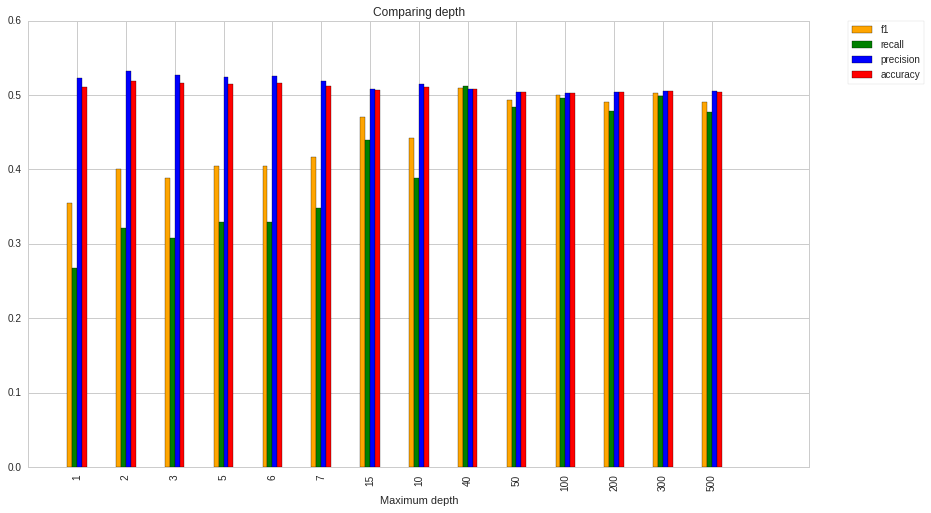

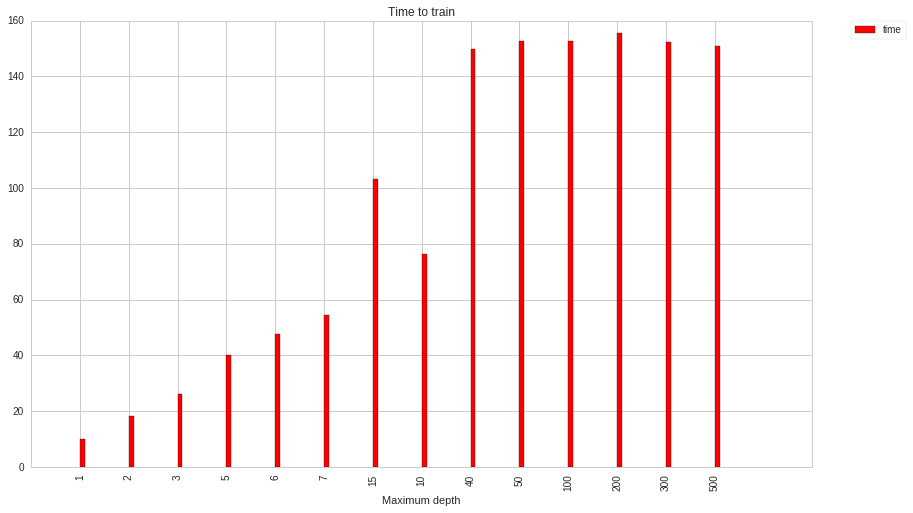

 f1 for depth 40 max value 0.509896871615
recall for depth 40 max value 0.512091307501
precision for depth 2 max value 0.532561429245
accuracy for depth 2 max value 0.519307211811


In [19]:
metric_results_RF={}
for metric in cls_metrics:
    metric_results_RF.update({metric:[]})
    metric_results_RF.update({'time':[]});
depths =  np.array([1,2,3,5,6,7,15,10,40,50,100,200,300,500])
    
for depth in depths:
    start_timer = time()
    clf = ensemble.RandomForestClassifier(max_depth=depth,n_estimators=100) 
    clf.fit(X_train_trans, Y_train_shift)
    
    Y_pred_test = clf.predict(X_test_trans)
    end_timer = time()
    print depth,
    
    for metric in cls_metrics:         
        temp = cls_metrics[metric](Y_test_shift, Y_pred_test)
        metric_results_RF[metric].append(temp)
    
    metric_results_RF['time'].append(end_timer-start_timer)
    
mywidth = 0.1
shift = -(len(cls_metrics)-1)/2*mywidth

for metric in cls_metrics:
       
    plt.bar(np.array(range(1,len(depths)+1))+shift, metric_results_RF[metric], width=mywidth,
        label = metric, color=metric_colors[metric])
    shift += mywidth
   
plt.title("Comparing depth")
plt.xlabel('Maximum depth')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(np.array(range(1,len(depths)+1)), depths, rotation='vertical')
plt.show()    

plt.bar(np.array(range(1,len(depths)+1)), metric_results_RF['time'], width=mywidth,
        label = 'time', color=metric_colors[metric])
plt.title("Time to train")
plt.xlabel('Maximum depth')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(np.array(range(1,len(depths)+1)), depths, rotation='vertical')

plt.show()

for metric in cls_metrics:
    print metric, 'for depth', depths[np.argmax(metric_results_RF[metric])] \
    ,'max value', max(metric_results_RF[metric])

10 20 30 40 50 70 100 200 300 400 500

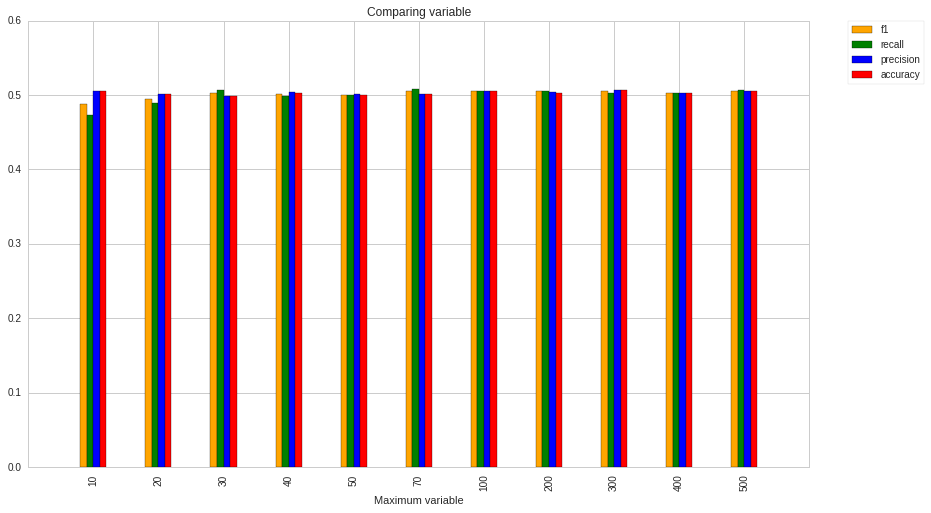

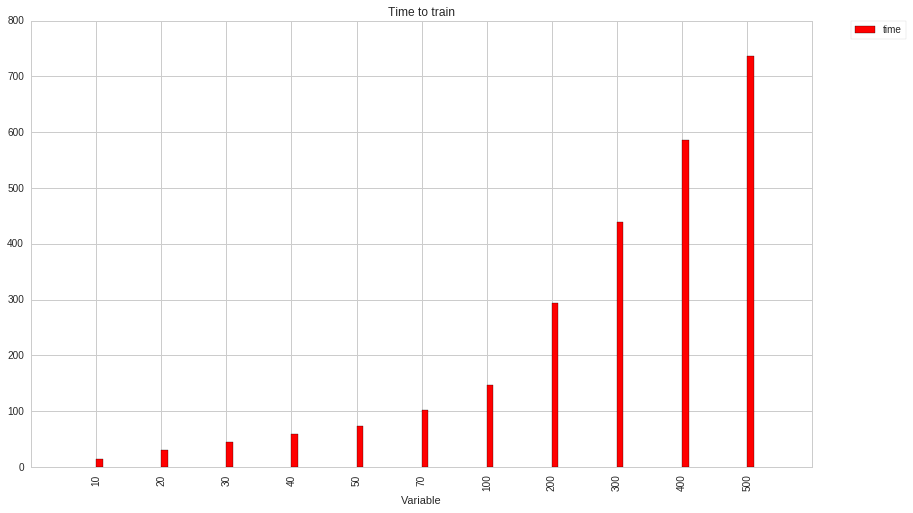

 max f1 for variable 500 max value 0.505737356566
max recall for variable 70 max value 0.508181732194
max precision for variable 300 max value 0.506658614881
max accuracy for variable 300 max value 0.506309546344


In [20]:
metric_results_RF={}
for metric in cls_metrics:
    metric_results_RF.update({metric:[]})
    metric_results_RF.update({'time':[]});
    
changed_variables =  np.array([10,20,30,40,50,70,100,200,300,400,500])
    
for changed_variable in changed_variables:
    start_timer = time()
    clf = ensemble.RandomForestClassifier(max_depth=30,n_estimators=changed_variable) 
    clf.fit(X_train_trans, Y_train_shift)
    
    Y_pred_test = clf.predict(X_test_trans)
    end_timer = time()
    print changed_variable,
    
    for metric in cls_metrics:         
        temp = cls_metrics[metric](Y_test_shift, Y_pred_test)
        metric_results_RF[metric].append(temp)
    
    metric_results_RF['time'].append(end_timer-start_timer)
    
mywidth = 0.1
shift = -(len(cls_metrics)-1)/2*mywidth

for metric in cls_metrics:
       
    plt.bar(np.array(range(1,len(changed_variables)+1))+shift, metric_results_RF[metric], width=mywidth,
        label = metric, color=metric_colors[metric])
    shift += mywidth
   
plt.title("Comparing variable")
plt.xlabel('Maximum variable')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(np.array(range(1,len(changed_variables)+1)), changed_variables, rotation='vertical')
plt.show()    

plt.bar(np.array(range(1,len(changed_variables)+1)), metric_results_RF['time'], width=mywidth,
        label = 'time', color=metric_colors[metric])
plt.title("Time to train")
plt.xlabel('Variable')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(np.array(range(1,len(changed_variables)+1)), changed_variables, rotation='vertical')
plt.show()

for metric in cls_metrics:
    print 'max', metric, 'for variable', changed_variables[np.argmax(metric_results_RF[metric])] \
    ,'max value', max(metric_results_RF[metric])


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27

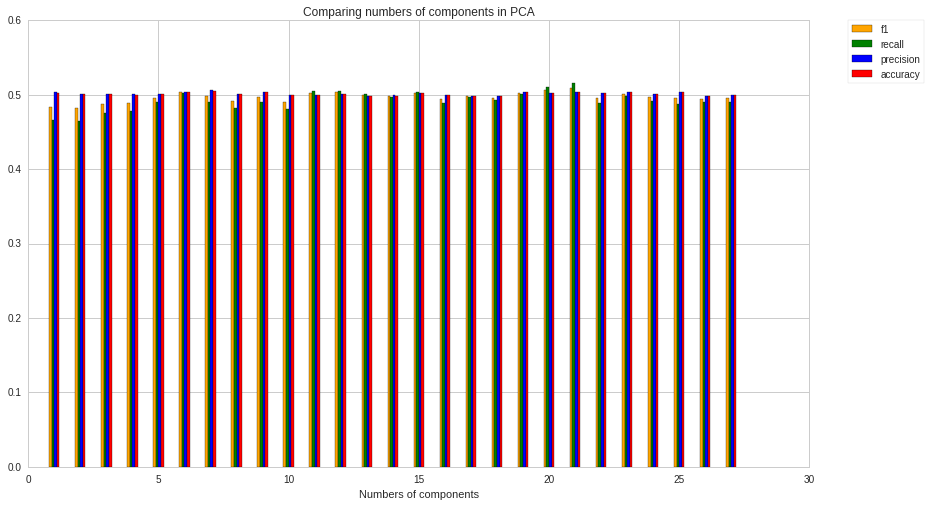

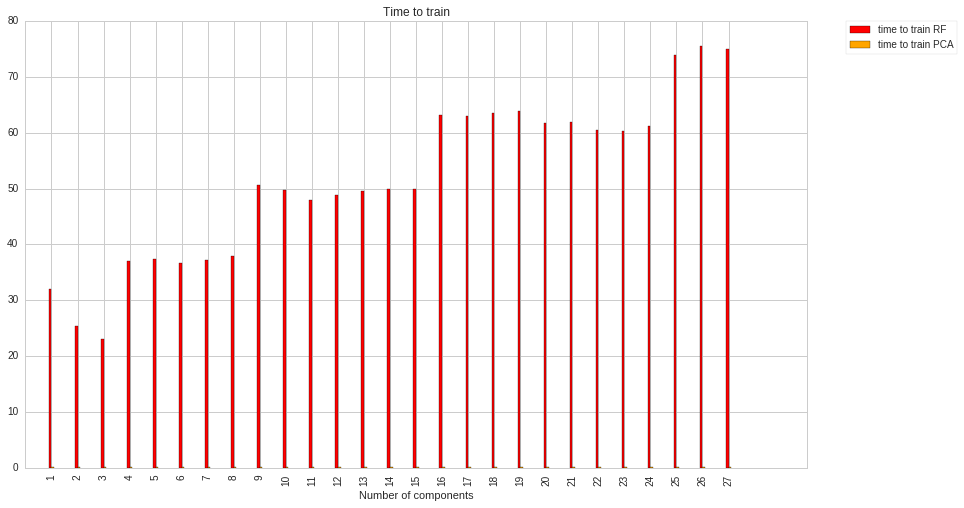

 max f1 for number of components 21 max value 0.509439840489
max recall for number of components 21 max value 0.515559479144
max precision for number of components 7 max value 0.50580846702
max accuracy for number of components 7 max value 0.50533156666


In [21]:
metric_results_PCA={}
for metric in cls_metrics:
    metric_results_PCA.update({metric:[]});
    metric_results_PCA.update({'time':[]});
    metric_results_PCA.update({'time_PCA':[]});
pca_numbers = np.array(range(1,X.shape[2]+1))  
clf = ensemble.RandomForestClassifier(max_depth=30,n_estimators=50) 
    
for pca_number in pca_numbers :
    print pca_number,
    pca=decomposition.PCA(n_components = pca_number)
    start_timer_PCA=time()
    X_train_trans_PCA = pca.fit_transform(X_train_trans)
    X_test_trans_PCA = pca.transform(X_test_trans)
    end_timer_PCA=time()
    
    start_timer=time()
    clf.fit(X_train_trans_PCA, Y_train_shift)
    Y_pred_test_PCA    = clf.predict(X_test_trans_PCA)
    end_timer=time()

    
    for metric in cls_metrics:         
        temp = cls_metrics[metric](Y_test_shift, Y_pred_test_PCA)
        metric_results_PCA[metric].append(temp)
    
    metric_results_PCA['time'].append(end_timer-start_timer)
    metric_results_PCA['time_PCA'].append(end_timer_PCA-start_timer_PCA)

    mywidth =0.1
    
    
shift=-(len(cls_metrics)-1)/2*mywidth
for metric in cls_metrics:
        
    plt.bar(pca_numbers+shift, metric_results_PCA[metric], width=mywidth,
        label = metric, color=metric_colors[metric])
    shift += mywidth
   

plt.title("Comparing numbers of components in PCA")
plt.xlabel('Numbers of components')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.bar(np.array(range(1,len(pca_numbers)+1))-mywidth, metric_results_PCA['time'], width=mywidth,
        label = 'time to train RF', color='r')
plt.bar(np.array(range(1,len(pca_numbers)+1)), metric_results_PCA['time_PCA'], width=mywidth,
        label = 'time to train PCA', color='orange')

plt.title("Time to train")
plt.xlabel('Number of components')
plt.xticks(np.array(range(1,len(pca_numbers)+1)), pca_numbers, rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



for metric in cls_metrics:
    print 'max', metric, 'for number of components', pca_numbers[np.argmax(metric_results_PCA[metric])] \
    ,'max value', max(metric_results_PCA[metric])

In [22]:
metrics.classification_report(Y_test_shift, Y_pred_test)

'             precision    recall  f1-score   support\n\n        0.0       0.50      0.50      0.50     31679\n        1.0       0.50      0.51      0.51     31717\n\navg / total       0.50      0.50      0.50     63396\n'